In [ ]:
# for pep-8
!pip install nb_black
!pip install pycodestyle_magic
!pip install pycodestyle
!pip install flake8

  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.6/62.6 kB 7.5 MB/s eta 0:00:00


In [ ]:
!pip install -q -U watermark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 9.7 MB/s eta 0:00:00


In [ ]:
!pip install -qq transformers

In [ ]:
%reload_ext watermark
%watermark -v -p numpy,pandas,torch,transformers

Python implementation: CPython
Python version       : 3.10.12
IPython version      : 7.34.0

numpy       : 1.23.5
pandas      : 1.5.3
torch       : 2.1.0+cu118
transformers: 4.35.2



In [ ]:
# @title Setup & Config
import transformers
from transformers import (
    BertModel,
    BertTokenizer,
    AdamW,
    get_linear_schedule_with_warmup,
)
import torch
import os
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap
import zipfile

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style="whitegrid", palette="muted", font_scale=1.2)

HAPPY_COLORS_PALETTE = [
    "#01BEFE",
    "#FFDD00",
    "#FF7D00",
    "#FF006D",
    "#ADFF02",
    "#8F00FF",
]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams["figure.figsize"] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

## Download the dataset

In [ ]:
import pandas as pd

# Try different encodings
encodings_to_try = ['utf-8', 'ISO-8859-1', 'cp1252']

for encoding in encodings_to_try:
    try:
        df = pd.read_csv("/content/all-data.csv", encoding=encoding)
        # If successful, print the encoding and break out of the loop
        print(f"Successfully read the CSV file with encoding: {encoding}")
        break
    except UnicodeDecodeError:
        # If decoding fails, try the next encoding
        print(f"Failed to read with encoding: {encoding}")
        continue

Failed to read with encoding: utf-8
Successfully read the CSV file with encoding: ISO-8859-1


In [ ]:
df.columns = ["Sentiment", "review"]

In [ ]:
df = df.rename(
    columns={
        "neutral": "Sentiment",
        "According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .": "statement",
    }
)

In [ ]:
df.columns

Index(['Sentiment', 'review'], dtype='object')

In [ ]:
df = df[["Sentiment", "review"]]

In [ ]:
df.head()

,Sentiment,review
0,neutral,Technopolis plans to develop in stages an area...
1,negative,The international electronic industry company ...
2,positive,With the new production plant the company woul...
3,positive,According to the company 's updated strategy f...
4,positive,FINANCING OF ASPOCOMP 'S GROWTH Aspocomp is ag...


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4845 entries, 0 to 4844
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Sentiment  4845 non-null   object
 1   review     4845 non-null   object
dtypes: object(2)
memory usage: 75.8+ KB


Text(0.5, 0, 'Sentiment')

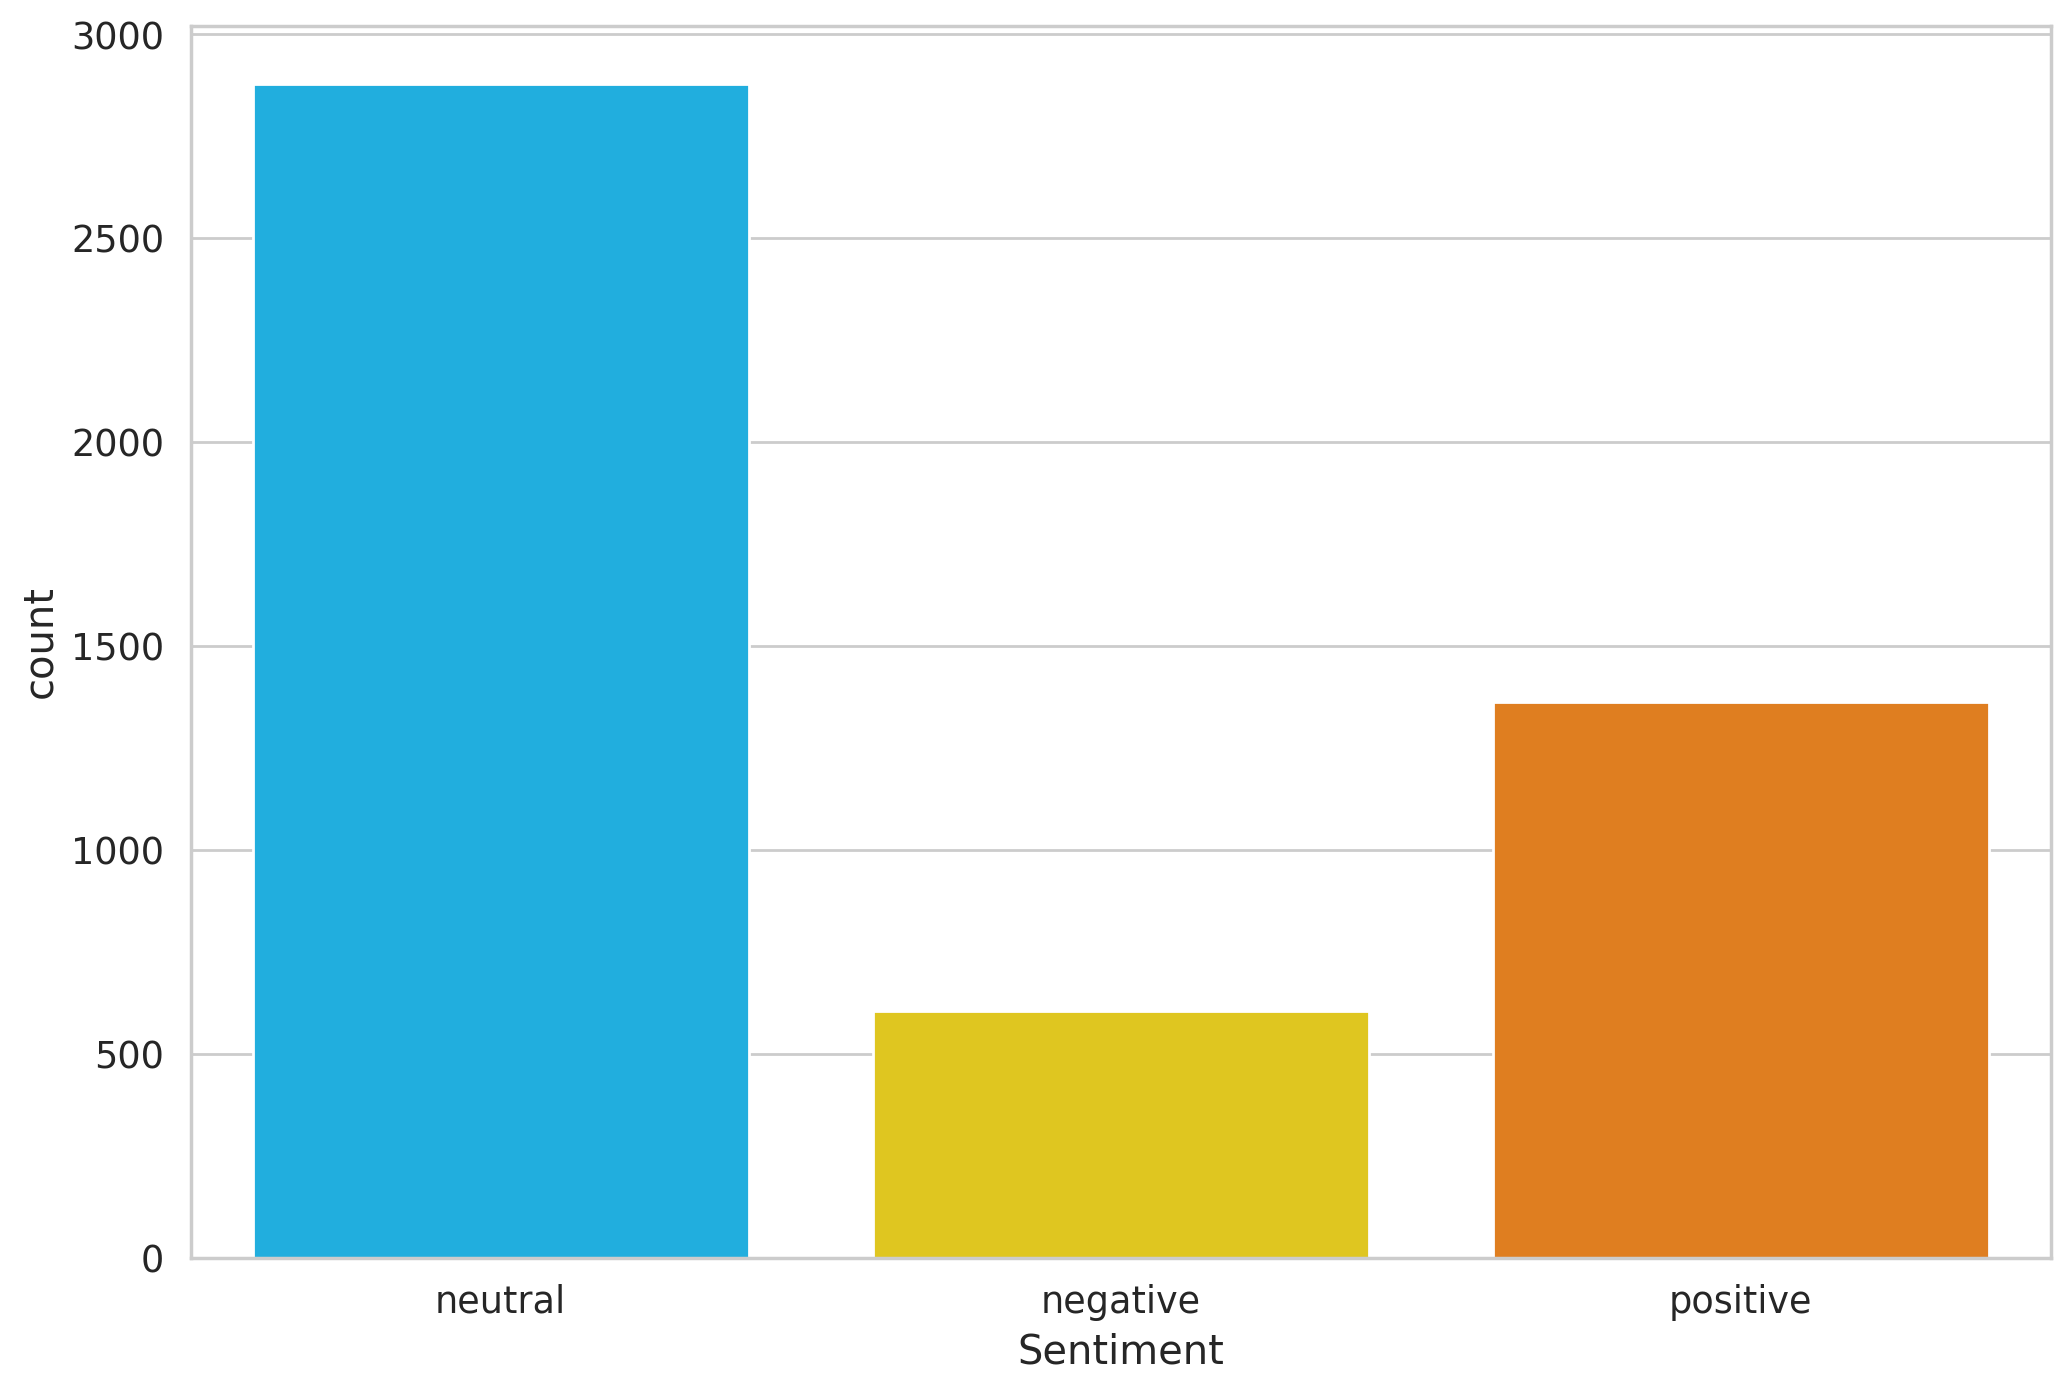

In [ ]:
sns.countplot(x="Sentiment", data=df)
plt.xlabel("Sentiment")

In [ ]:
# to transform string labels to integer values
LE = LabelEncoder()
df["Sentiment_enc"] = LE.fit_transform(df["Sentiment"].values)

df.tail(10)

,Sentiment,review,Sentiment_enc
4835,negative,"Operating profits in the half were 0.8 m , do...",0
4836,negative,"Sales in Finland decreased by 2.0 % , and inte...",0
4837,negative,The company said that its comparable operating...,0
4838,negative,Operating result for the 12-month period decre...,0
4839,negative,HELSINKI Thomson Financial - Shares in Cargote...,0
4840,negative,LONDON MarketWatch -- Share prices ended lower...,0
4841,neutral,Rinkuskiai 's beer sales fell by 6.5 per cent ...,1
4842,negative,Operating profit fell to EUR 35.4 mn from EUR ...,0
4843,negative,Net sales of the Paper segment decreased to EU...,0
4844,negative,Sales in Finland decreased by 10.5 % in Januar...,0


In [ ]:
class_names = ["negative", "neutral", "positive"]

# Data Preprocessing
You might already know that Machine Learning models don't work with raw text. You need to convert text to numbers (of some sort). BERT requires even more attention (good one, right?). Here are the requirements:

- Add special tokens to separate sentences and do classification
- Pass sequences of constant length (introduce padding)
- Create array of 0s (pad token) and 1s (real token) called attention mask

The Transformers library provides (you've guessed it) a wide variety of Transformer models (including BERT). It works with TensorFlow and PyTorch! It also includes prebuild tokenizers that do the heavy lifting for us!

In [ ]:
PRE_TRAINED_MODEL_NAME = "bert-base-cased"

You can use a cased and uncased version of BERT and tokenizer. I've experimented with both. The cased version works better. Intuitively, that makes sense, since "BAD" might convey more sentiment than "bad".

Let's load a pre-trained [BertTokenizer](https://huggingface.co/transformers/model_doc/bert.html#berttokenizer):

In [ ]:
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

tokenizer_config.json:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

We'll use this text to understand the tokenization process:

In [ ]:
sample_txt = "Sales of clothing developed best."

Some basic operations can convert the text to tokens and tokens to unique integers (ids):

In [ ]:
tokens = tokenizer.tokenize(sample_txt)
token_ids = tokenizer.convert_tokens_to_ids(tokens)

print(f" Sentence: {sample_txt}")
print(f"   Tokens: {tokens}")
print(f"Token IDs: {token_ids}")

 Sentence: Sales of clothing developed best.
   Tokens: ['Sales', 'of', 'clothing', 'developed', 'best', '.']
Token IDs: [15689, 1104, 5413, 1872, 1436, 119]


## Special Tokens
[SEP] - marker for ending of a sentence

In [ ]:
tokenizer.sep_token, tokenizer.sep_token_id

('[SEP]', 102)

[CLS] - we must add this token to the start of each sentence, so BERT knows we're doing classification

In [ ]:
tokenizer.cls_token, tokenizer.cls_token_id

('[CLS]', 101)

There is also a special token for padding:

In [ ]:
tokenizer.pad_token, tokenizer.pad_token_id

('[PAD]', 0)

In [ ]:
tokenizer.unk_token, tokenizer.unk_token_id

('[UNK]', 100)

All of that work can be done using the encode_plus() method:

In [ ]:
encoding = tokenizer.encode_plus(
    sample_txt,
    max_length=12,
    add_special_tokens=True,  # Add '[CLS]' and '[SEP]'
    return_token_type_ids=False,
    padding="max_length",
    return_attention_mask=True,
    return_tensors="pt",  # Return PyTorch tensors
)

encoding.keys()

dict_keys(['input_ids', 'attention_mask'])

The token ids are now stored in a Tensor and padded to a length of 32:

In [ ]:
print(len(encoding["input_ids"][0]))
encoding["input_ids"][0]

12


tensor([  101, 15689,  1104,  5413,  1872,  1436,   119,   102,     0,     0,
            0,     0])

The attention mask has the same length:

In [ ]:
print(len(encoding["attention_mask"][0]))
encoding["attention_mask"]

12


tensor([[1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0]])

We can inverse the tokenization to have a look at the special tokens:

In [ ]:
tokenizer.convert_ids_to_tokens(encoding["input_ids"][0])

['[CLS]',
 'Sales',
 'of',
 'clothing',
 'developed',
 'best',
 '.',
 '[SEP]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]']

## Choosing Sequence Length
BERT works with fixed-length sequences. We'll use a simple strategy to choose the max length. Let's store the token length of each review:

In [ ]:
df.columns

Index(['Sentiment', 'review', 'Sentiment_enc'], dtype='object')

In [ ]:
token_lens = []

for txt in df.review:
    tokens = tokenizer.encode(txt, max_length=512, truncation=True)
    token_lens.append(len(tokens))

and plot the distribution:

Text(0.5, 0, 'Token count')

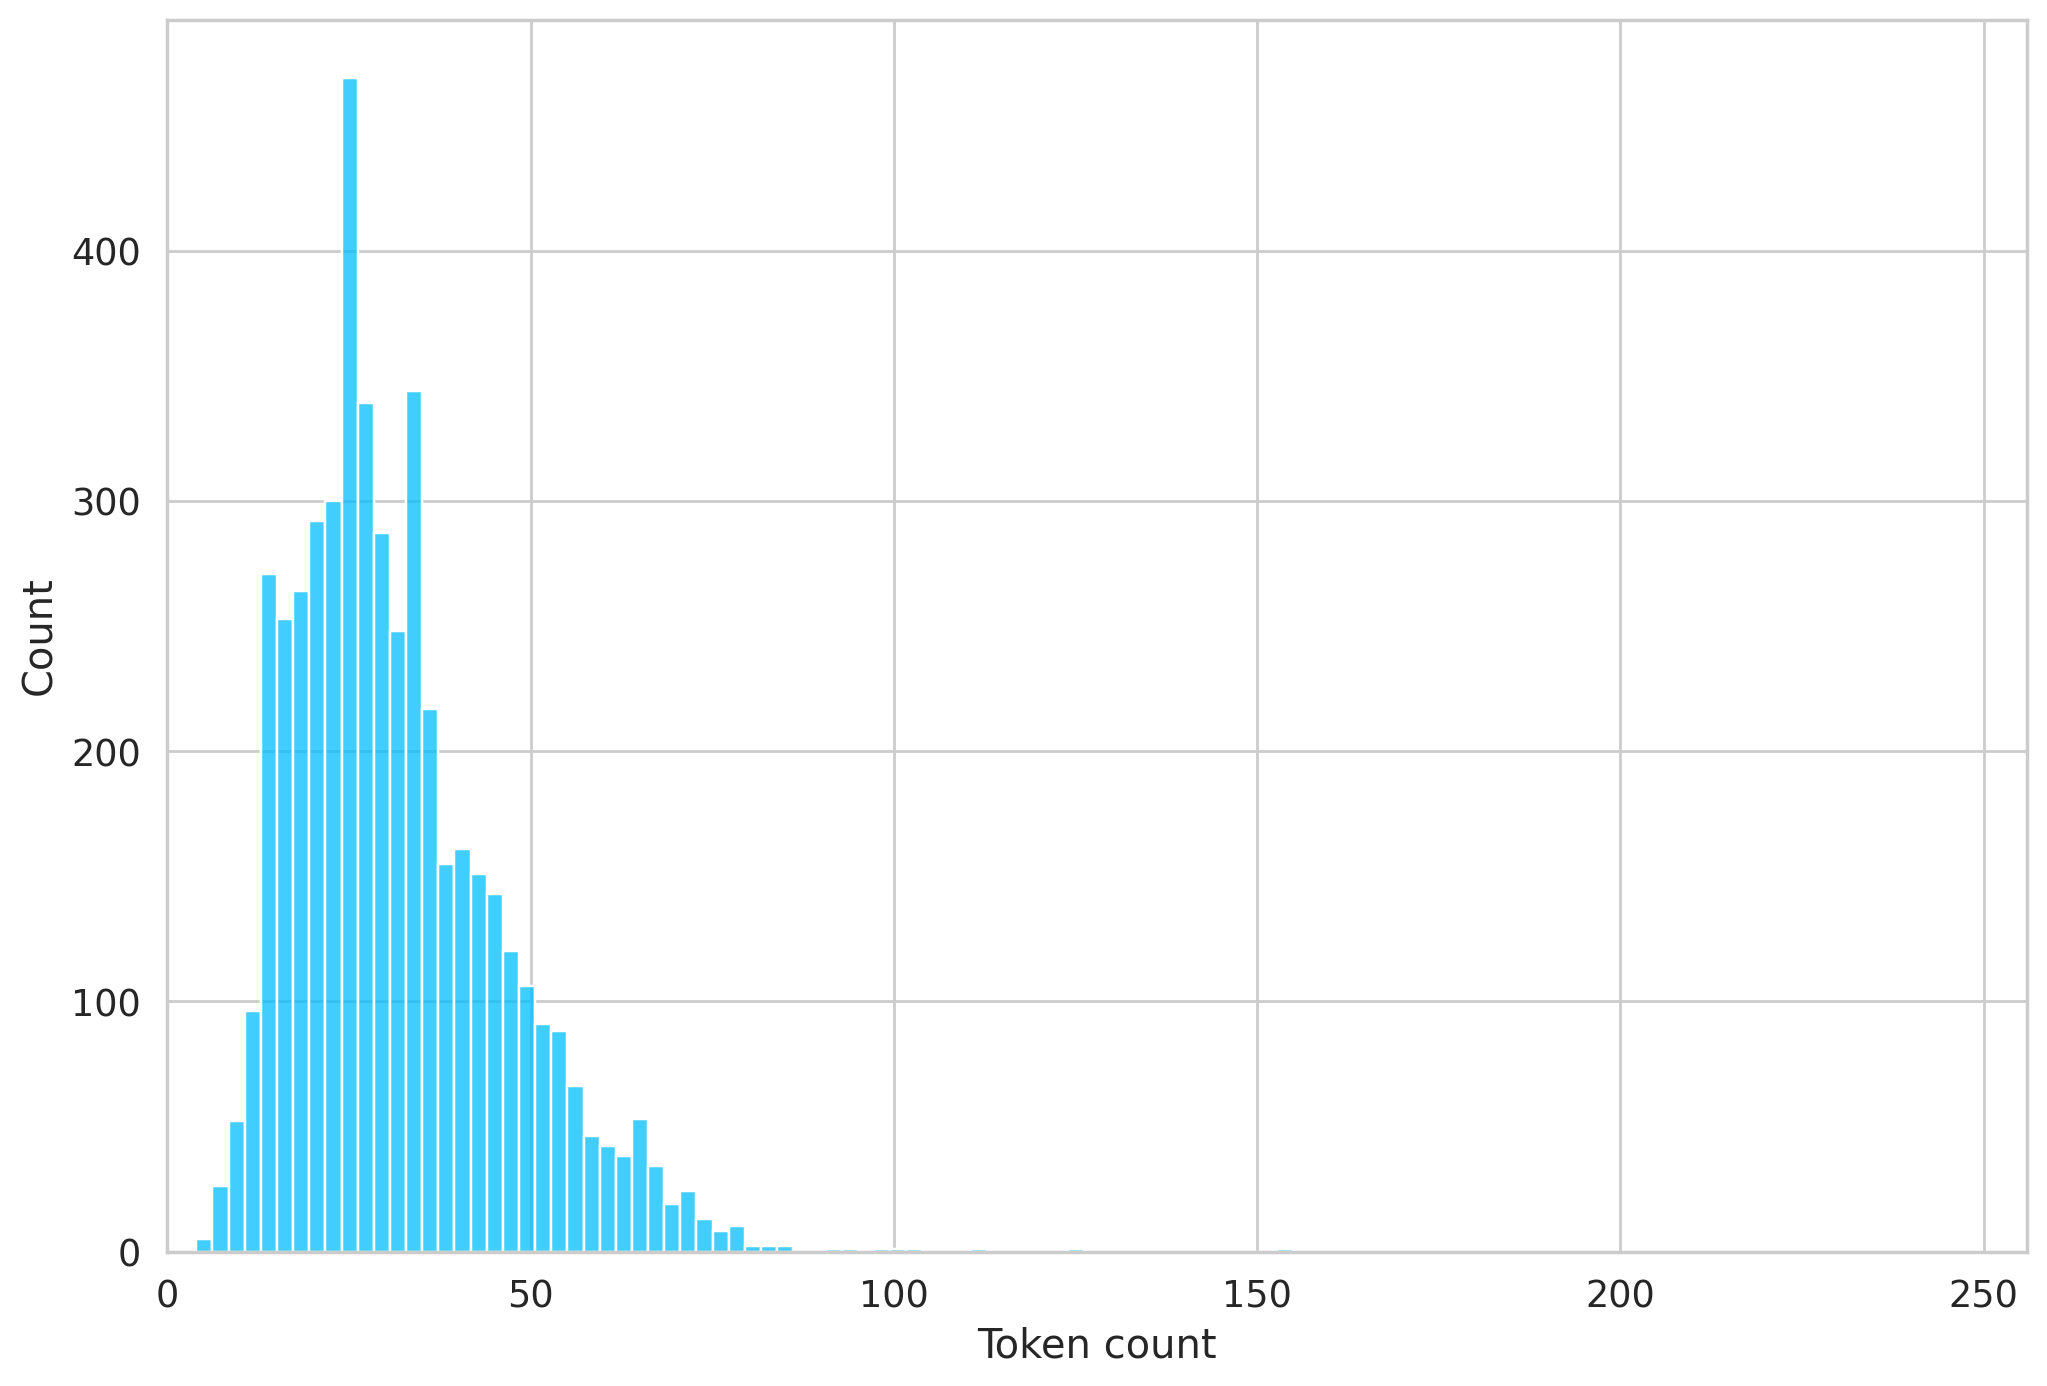

In [ ]:
sns.histplot(token_lens)
plt.xlim([0, 256])
plt.xlabel("Token count")

Most of the reviews seem to contain less than 25 tokens, but we'll be on the safe side and choose a maximum length of 35.

In [ ]:
MAX_LEN = 72

We have all building blocks required to create a PyTorch dataset. Let's do it:

In [ ]:
class FinancialReviewDataset(Dataset):
    def __init__(self, reviews, targets, tokenizer, max_len):
        self.reviews = reviews
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.reviews)

    def __getitem__(self, item):
        review = str(self.reviews[item])
        target = self.targets[item]

        encoding = self.tokenizer.encode_plus(
            review,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding="max_length",
            truncation=True,
            return_attention_mask=True,
            return_tensors="pt",
        )

        return {
            "review_text": review,
            "input_ids": encoding["input_ids"].flatten(),
            "attention_mask": encoding["attention_mask"].flatten(),
            "targets": torch.tensor(target, dtype=torch.long),
        }

The tokenizer is doing most of the heavy lifting for us. We also return the review texts, so it'll be easier to evaluate the predictions from our model. Let's split the data:

In [ ]:
df_train, df_test = train_test_split(df, test_size=0.1, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)

In [ ]:
df.shape

(4845, 3)

In [ ]:
df_train.shape, df_val.shape, df_test.shape

((4360, 3), (242, 3), (243, 3))

We also need to create a couple of data loaders. Here's a helper function to do it:

In [ ]:
def create_data_loader(df, tokenizer, max_len, batch_size):
    ds = FinancialReviewDataset(
        reviews=df.review.to_numpy(),
        targets=df.Sentiment_enc.to_numpy(),
        tokenizer=tokenizer,
        max_len=max_len,
    )

    return DataLoader(ds, batch_size=batch_size, num_workers=4)

In [ ]:
BATCH_SIZE = 16

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Let's have a look at an example batch from our training data loader:

In [ ]:
data = next(iter(train_data_loader))
data.keys()

dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])

In [ ]:
print(data["input_ids"].shape)
print(data["attention_mask"].shape)
print(data["targets"].shape)

torch.Size([16, 72])
torch.Size([16, 72])
torch.Size([16])


# Sentiment Classification with BERT and Hugging Face
There are a lot of helpers that make using BERT easy with the Transformers library. Depending on the task you might want to use [BertForSequenceClassification](https://huggingface.co/transformers/model_doc/bert.html#bertforsequenceclassification), [BertForQuestionAnswering](https://huggingface.co/transformers/model_doc/bert.html#bertforquestionanswering) or something else.

But who cares, right? We're hardcore! We'll use the basic [BertModel](https://huggingface.co/transformers/model_doc/bert.html#bertmodel) and build our sentiment classifier on top of it. Let's load the model:

In [ ]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME, return_dict=False)

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

And try to use it on the encoding of our sample text:

In [ ]:
outputs = bert_model(
  input_ids=encoding['input_ids'],
  attention_mask=encoding['attention_mask'])


The last_hidden_state is a sequence of hidden states of the last layer of the model.

In [ ]:
outputs[0].shape

torch.Size([1, 12, 768])

We have the hidden state for each of our 32 tokens (the length of our example sequence). But why 768? This is the number of hidden units in the feedforward-networks. We can verify that by checking the config:

In [ ]:
bert_model.config.hidden_size

768

We can use all of this knowledge to create a classifier that uses the BERT model:

In [ ]:
class SentimentPredictor(nn.Module):
    def __init__(self, n_classes):
        super(SentimentPredictor, self).__init__()
        self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME, return_dict=False)
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)

    def forward(self, input_ids, attention_mask):
        _, pooled_output = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        output = self.drop(pooled_output)
        return self.out(output)

Our classifier delegates most of the heavy lifting to the BertModel. We use a dropout layer for some regularization and a fully-connected layer for our output. Note that we're returning the raw output of the last layer since that is required for the cross-entropy loss function in PyTorch to work.

This should work like any other PyTorch model. Let's create an instance and move it to the GPU:

In [ ]:
model = SentimentPredictor(len(class_names))
model = model.to(device)

We'll move the example batch of our training data to the GPU:

In [ ]:
input_ids = data["input_ids"].to(device)
attention_mask = data["attention_mask"].to(device)

print(input_ids.shape)  # batch size x seq length
print(attention_mask.shape)  # batch size x seq length

torch.Size([16, 72])
torch.Size([16, 72])


In [ ]:
type(attention_mask)

torch.Tensor

In [ ]:
attention_mask

tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]], device='cuda:0')

To get the predicted probabilities from our trained model, we'll apply the softmax function to the outputs:

In [ ]:
F.softmax(model(input_ids, attention_mask), dim=1)

tensor([[0.2138, 0.4660, 0.3202],
        [0.2362, 0.2975, 0.4663],
        [0.3297, 0.2537, 0.4166],
        [0.2372, 0.3578, 0.4050],
        [0.4810, 0.2871, 0.2318],
        [0.2203, 0.4231, 0.3566],
        [0.2649, 0.3273, 0.4078],
        [0.3303, 0.3629, 0.3067],
        [0.3725, 0.1856, 0.4419],
        [0.3044, 0.2248, 0.4708],
        [0.3169, 0.1775, 0.5056],
        [0.3226, 0.1909, 0.4866],
        [0.1853, 0.4040, 0.4107],
        [0.3143, 0.2686, 0.4171],
        [0.2871, 0.2403, 0.4726],
        [0.1359, 0.4342, 0.4299]], device='cuda:0', grad_fn=<SoftmaxBackward0>)

## Training

To reproduce the training procedure from the BERT paper, we'll use the [AdamW](https://huggingface.co/transformers/main_classes/optimizer_schedules.html#adamw) optimizer provided by Hugging Face. It corrects weight decay, so it's similar to the original paper. We'll also use a linear scheduler with no warmup steps:

In [ ]:
EPOCHS = 10

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
    optimizer, num_warmup_steps=0, num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


How do we come up with all hyperparameters? The BERT authors have some recommendations for fine-tuning:

- Batch size: 16, 32
- Learning rate (Adam): 5e-5, 3e-5, 2e-5
-Number of epochs: 2, 3, 4

We're going to ignore the number of epochs recommendation but stick with the rest. Note that increasing the batch size reduces the training time significantly, but gives you lower accuracy.

Let's continue with writing a helper function for training our model for one epoch:

In [ ]:
def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
    model = model.train()

    losses = []
    correct_predictions = 0

    for d in data_loader:
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        targets = d["targets"].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)

        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs, targets)

        correct_predictions += torch.sum(preds == targets)
        losses.append(loss.item())

        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()

    losses = []
    correct_predictions = 0

    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            _, preds = torch.max(outputs, dim=1)

            loss = loss_fn(outputs, targets)

            correct_predictions += torch.sum(preds == targets)
            losses.append(loss.item())

    return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
train_acc = []
valid_acc = []

Using those two, we can write our training loop. We'll also store the training history:

In [ ]:
%%time
history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,
    loss_fn,
    optimizer,
    device,
    scheduler,
    len(df_train)
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn,
    device,
    len(df_val)
  )
  train_acc=train_acc.cpu()
  val_acc=val_acc.cpu()
  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)
#   history=torch.tensor(history)
#   history=history.detach()

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

Epoch 1/10
----------


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train loss 0.5977724430598182 accuracy 0.7536697247706422
Val   loss 0.4016556442948058 accuracy 0.8388429752066116

Epoch 2/10
----------
Train loss 0.2841828857606529 accuracy 0.9004587155963303
Val   loss 0.6879000727203675 accuracy 0.8140495867768596

Epoch 3/10
----------
Train loss 0.16085724750424535 accuracy 0.9497706422018349
Val   loss 0.7265137353388127 accuracy 0.8429752066115703

Epoch 4/10
----------
Train loss 0.09242575964122847 accuracy 0.976605504587156
Val   loss 0.804991188342683 accuracy 0.8429752066115703

Epoch 5/10
----------
Train loss 0.05558726593366766 accuracy 0.9876146788990826
Val   loss 0.9222470193708432 accuracy 0.8429752066115703

Epoch 6/10
----------
Train loss 0.030315567973524422 accuracy 0.9926605504587156
Val   loss 0.9922251177194994 accuracy 0.8388429752066116

Epoch 7/10
----------
Train loss 0.020773748379697914 accuracy 0.9954128440366973
Val   loss 1.0967650705424603 accuracy 0.8347107438016529

Epoch 8/10
----------
Train loss 0.012347833

Note that we're storing the state of the best model, indicated by the highest validation accuracy.

Whoo, this took some time! We can look at the training vs validation accuracy:

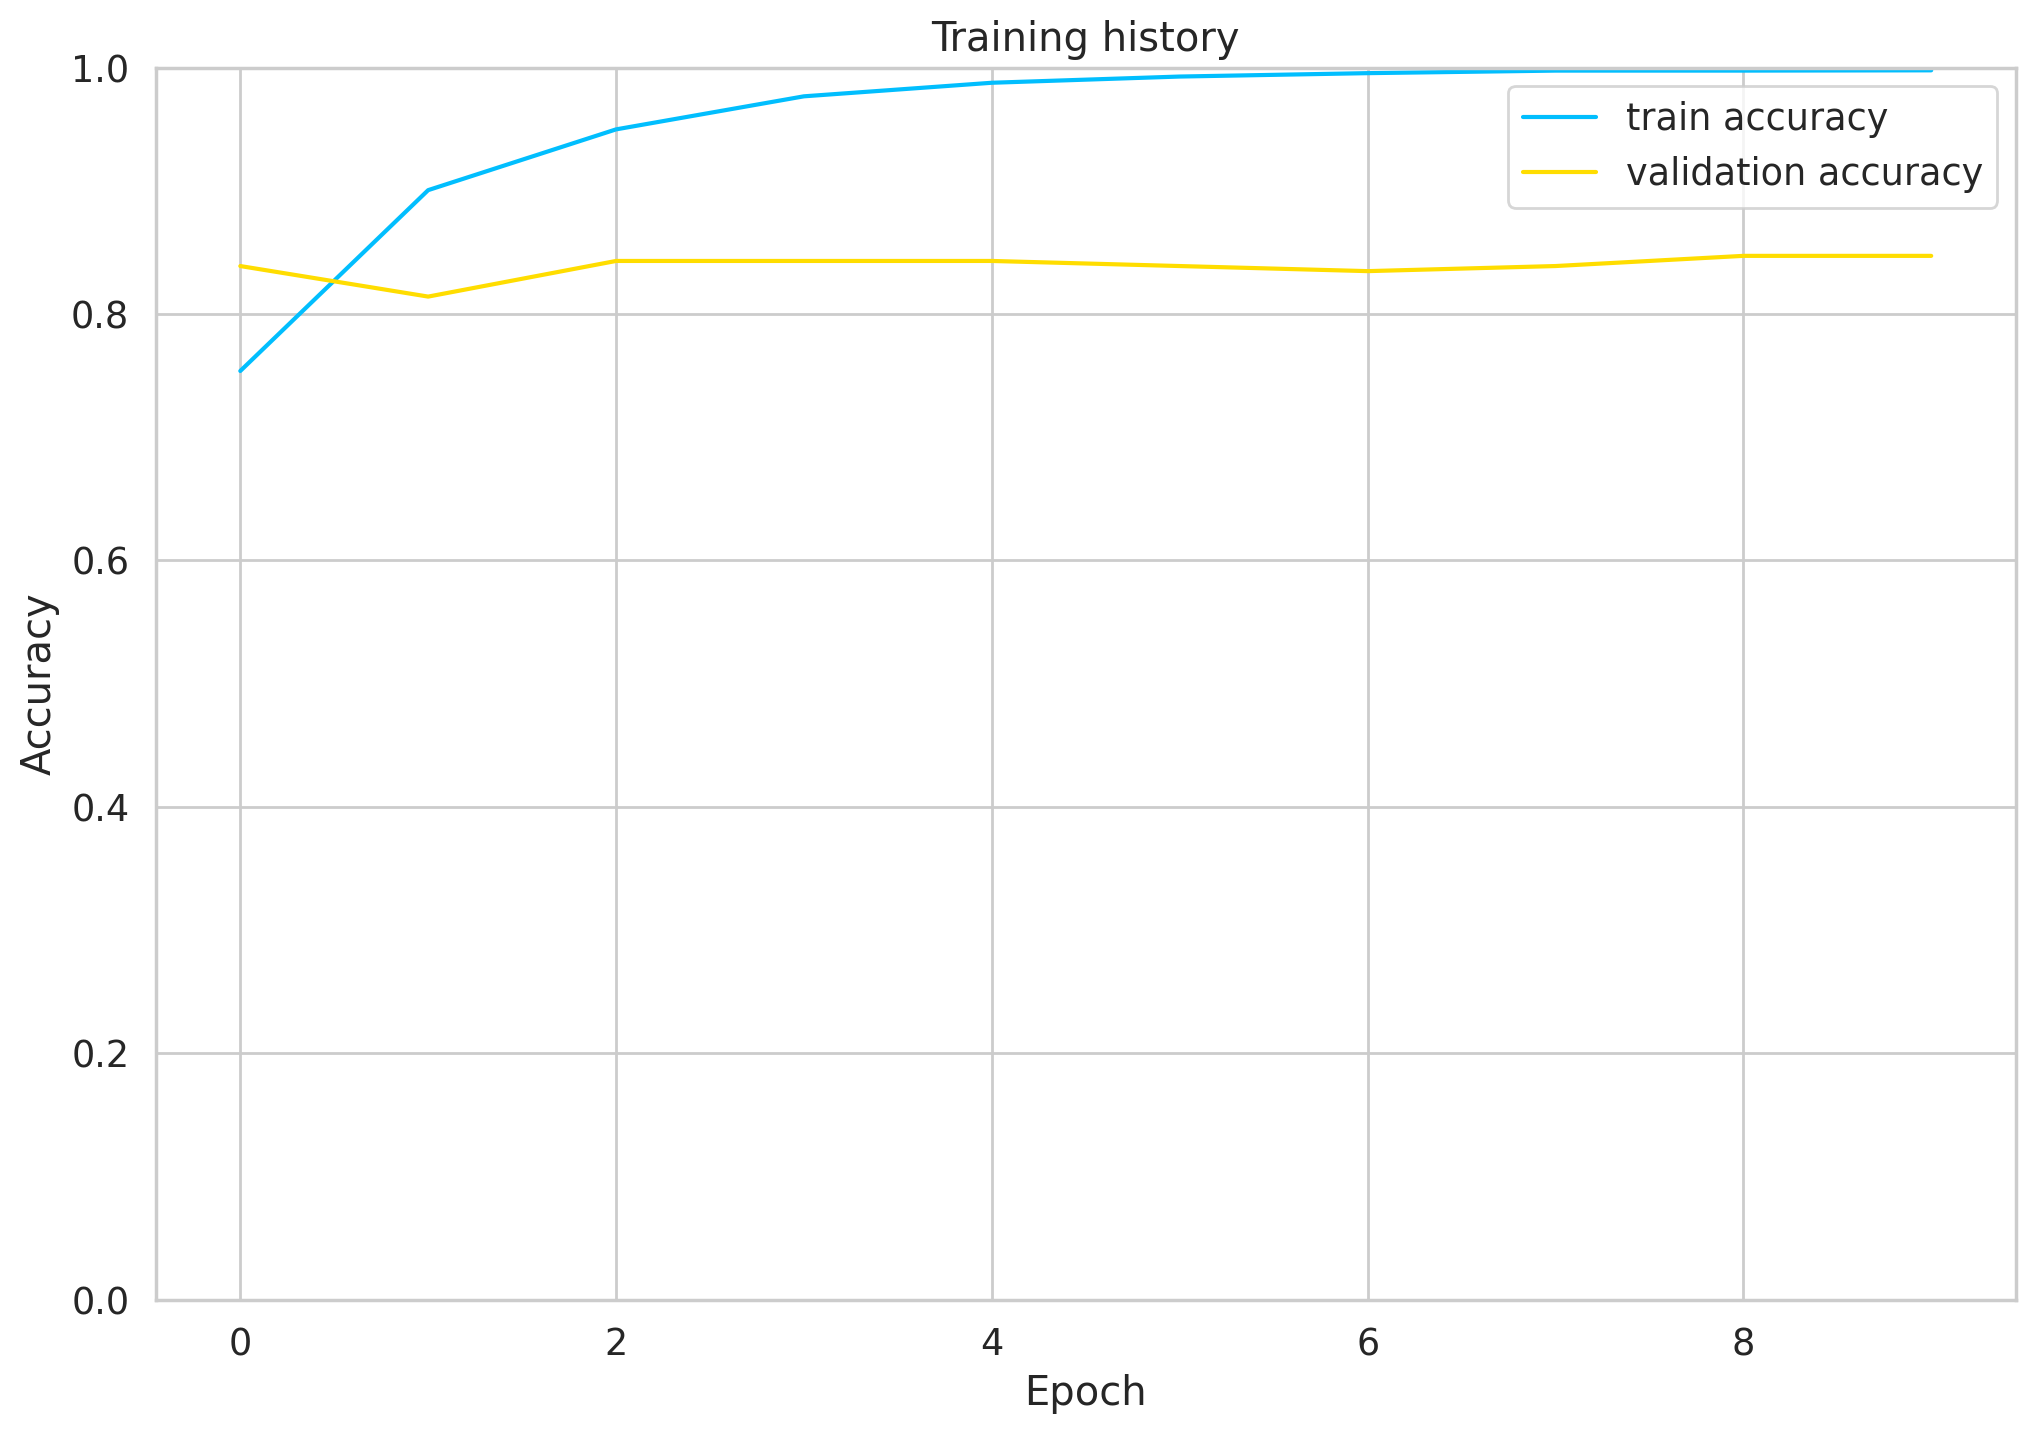

In [ ]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

The training accuracy starts to approach 100% after 6 epochs or so.

In [ ]:
model.load_state_dict(
    torch.load(
        "best_model_state.bin",
        map_location=torch.device("cpu"),
    )
)

<All keys matched successfully>

# Evaluation
So how good is our model on predicting sentiment? Let's start by calculating the accuracy on the test data:

In [ ]:
test_acc, _ = eval_model(model, test_data_loader, loss_fn, device, len(df_test))

test_acc.item()

0.8436213991769548

Our model seems to generalize well as test accuracy is almost equal to validation accuracy.

We'll define a helper function to get the predictions from our model:

In [ ]:
def get_predictions(model, data_loader):
    model = model.eval()

    review_texts = []
    predictions = []
    prediction_probs = []
    real_values = []

    with torch.no_grad():
        for d in data_loader:

            texts = d["review_text"]
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            _, preds = torch.max(outputs, dim=1)

            probs = F.softmax(outputs, dim=1)

            review_texts.extend(texts)
            predictions.extend(preds)
            prediction_probs.extend(probs)
            real_values.extend(targets)

    predictions = torch.stack(predictions).cpu()
    prediction_probs = torch.stack(prediction_probs).cpu()
    real_values = torch.stack(real_values).cpu()
    return review_texts, predictions, prediction_probs, real_values

This is similar to the evaluation function, except that we're storing the text of the reviews and the predicted probabilities (by applying the softmax on the model outputs):

In [ ]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(model, test_data_loader)

Let's have a look at the classification report

In [ ]:
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

    negative       0.88      0.91      0.89        32
     neutral       0.86      0.87      0.86       135
    positive       0.81      0.76      0.78        76

    accuracy                           0.84       243
   macro avg       0.85      0.85      0.85       243
weighted avg       0.84      0.84      0.84       243



Looks like it is really hard to classify neutral (3 stars) reviews. And I can tell you from experience, looking at many reviews, those are hard to classify.

We'll continue with the confusion matrix:

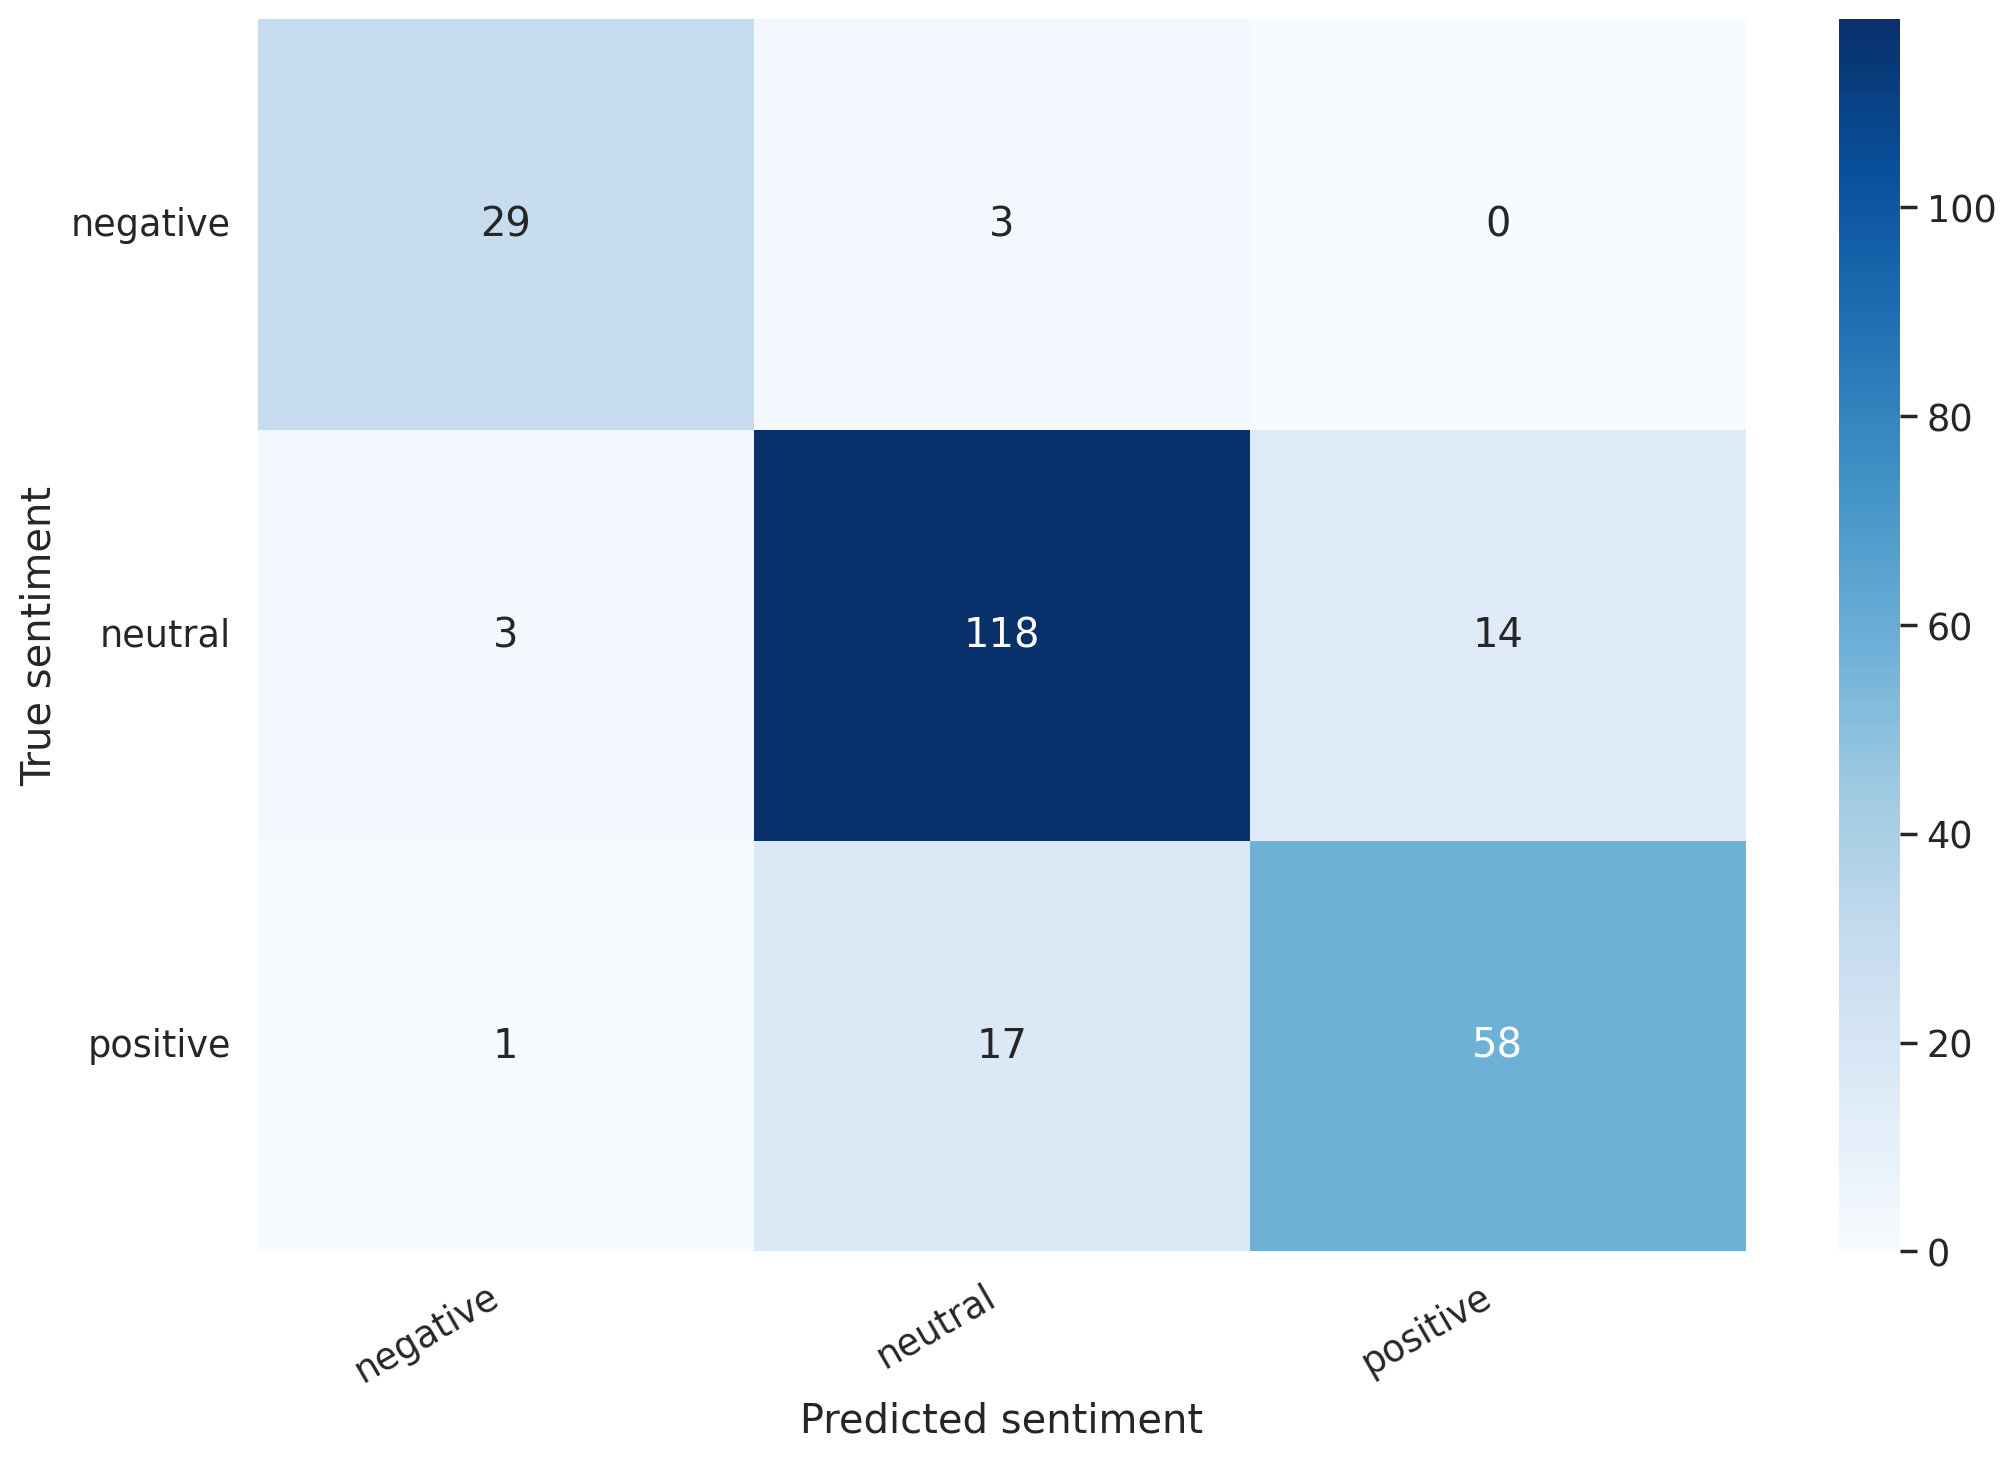

In [ ]:
def show_confusion_matrix(confusion_matrix):
    hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
    hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha="right")
    hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha="right")
    plt.ylabel("True sentiment")
    plt.xlabel("Predicted sentiment")


cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

That's a good overview of the performance of our model. But let's have a look at an example from our test data:

In [ ]:
review_text = "the news was worst but was good"

We have to use the tokenizer to encode the text:

In [ ]:
encoded_review = tokenizer.encode_plus(
    review_text,
    max_length=MAX_LEN,
    add_special_tokens=True,
    return_token_type_ids=False,
    pad_to_max_length=True,
    return_attention_mask=True,
    return_tensors="pt",
)

Let's get the predictions from our model:

In [ ]:
input_ids = encoded_review["input_ids"].to(device)
attention_mask = encoded_review["attention_mask"].to(device)

output = model(input_ids, attention_mask)
_, prediction = torch.max(output, dim=1)

print(f"Review text: {review_text}")
print(f"Sentiment  : {class_names[prediction]}")

Review text: the news was worst but was good
Sentiment  : negative
